<a href="https://colab.research.google.com/github/NicolaGabriele/powerline_Segmentation_project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
from pycocotools import mask
TRAIN_DIR = '/content/drive/MyDrive/trainingset'
TEST_DIR = '/content/drive/MyDrive/testset'
TRAIN_LABELS = '/content/drive/MyDrive/train.json'
TEST_LABELS =  '/content/drive/MyDrive/test.json'
IM_WIDTH = 700
IM_HEIGHT = 700

In [ ]:
def groupByImageId(jsonfile):
  data = jsonfile['annotations']
  labs = {}
  for k in data:
    if k['image_id'] in labs:
      labs[k['image_id']].append(k)
    else:
      labs[k['image_id']] = [k]
  return labs

In [ ]:
class PowerLineDataset(torch.utils.data.Dataset):
  def __init__(self,img_dir,img_labels):
    self.img_dir = img_dir
    self.img_labels = json.load(open(img_labels))
    self.categories = [] #lista delle etichette di classe
    for c in self.img_labels['categories']:
      self.categories.append(c['name'])

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_labels['images'][idx]['file_name'])
    label = groupByImageId(self.img_labels)[idx]
    image = torchvision.io.read_image(img_path)
    return image,label
  def __len__(self):
    return len(os.listdir(self.img_dir))

In [ ]:
#caricamento dei dataset di train e di test
train = PowerLineDataset(TRAIN_DIR, TRAIN_LABELS)
test = PowerLineDataset(TEST_DIR, TEST_LABELS)

(tensor([[[107, 106, 105,  ..., 150, 114, 122],
          [107, 107, 107,  ..., 124, 119, 136],
          [104, 105, 106,  ..., 107, 114, 102],
          ...,
          [128, 131, 120,  ...,  68,  69,  72],
          [133, 132, 130,  ...,  64,  68,  85],
          [136, 131, 135,  ...,  64,  68,  93]],
 
         [[117, 116, 116,  ..., 136,  98, 106],
          [117, 117, 118,  ..., 109, 103, 120],
          [113, 114, 115,  ...,  94,  99,  87],
          ...,
          [113, 116, 105,  ...,  55,  56,  59],
          [118, 117, 114,  ...,  51,  52,  69],
          [121, 116, 119,  ...,  51,  52,  77]],
 
         [[116, 115, 112,  ..., 101,  64,  72],
          [116, 116, 114,  ...,  76,  70,  86],
          [112, 113, 112,  ...,  62,  68,  54],
          ...,
          [ 80,  83,  72,  ...,  36,  37,  40],
          [ 85,  84,  81,  ...,  34,  36,  53],
          [ 88,  83,  86,  ...,  34,  36,  61]]], dtype=torch.uint8),
 [{'segmentation': [[559.2919685990337,
     1.8786902844873858

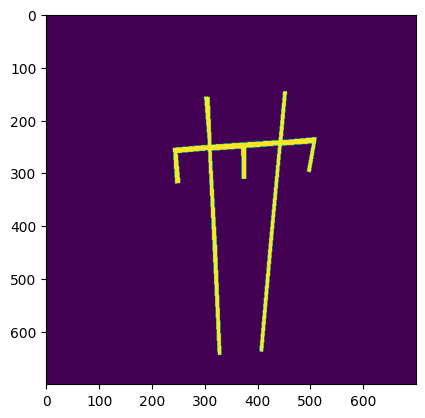

In [ ]:
def decodeSegmentationField(segmentation):
  return mask.decode(mask.merge(mask.frPyObjects(segmentation,IM_WIDTH,IM_HEIGHT)))

In [ ]:
#questo metodo è preso dai notebook e va adattato al caso specifico (loss ecc...)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_step = len(train)
batch_size = 64

num_epochs = 3

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train) for i in range(num_epochs + 1)]

def train(epoch,model,criterion,optimizer,reshape=True):
    for batch_idx, (images, labels) in enumerate(train):
        # Move tensors to the configured device
        if reshape:
            images = images.reshape(-1, 28*28)
        #images = images.to(device)
        #labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, loss.item()))

        train_losses.append(loss.item())
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(train)))